In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from scipy.integrate import quad
from scipy.optimize import minimize

In [2]:
def sample_gaussian_distribution(d):
    v = np.random.normal(0,1, size=d) 
    return v

sample_gaussian_distribution(5)
print(np.linalg.norm(sample_gaussian_distribution(10)))

2.8044740887534223


In [3]:
def euclidean_projection(point, lower_bounds, upper_bounds):
    def objective_function(z):
        return np.linalg.norm(z - point) ** 2

    constraints = []
    for i in range(len(lower_bounds)):
        constraints.append({'type': 'ineq', 'fun': lambda z, i=i: z[i] - lower_bounds[i]})
        constraints.append({'type': 'ineq', 'fun': lambda z, i=i: upper_bounds[i] - z[i]})

    result = minimize(objective_function, point, constraints=constraints, method='COBYLA')
    return result.x

# Example usage
point_to_project = np.array([4.0, -1])
point_to_project2 = np.array([4.0, -4])  
lower_bounds = [-3, -2,]
upper_bounds = [2, 3]
projected_point = euclidean_projection(point_to_project, lower_bounds, upper_bounds)
projected_point2 = euclidean_projection(point_to_project2, lower_bounds, upper_bounds)
print("Original Point:", point_to_project)
print("Projected Point:", projected_point)
print("Original Point:", point_to_project2)
print("Projected Point:", projected_point2)


Original Point: [ 4. -1.]
Projected Point: [ 2.     -0.9999]
Original Point: [ 4. -4.]
Projected Point: [ 2. -2.]


In [4]:
def feasible_set_func2(point,lower_bounds,upper_bounds):
    projected_point = np.maximum(lower_bounds, np.minimum(upper_bounds, point))
    return projected_point

lower_bounds = [-3, -2,]
upper_bounds = [2, 3]
point_to_project = np.array([5, -5])  
projected_point = feasible_set_func2(point_to_project,lower_bounds,upper_bounds)
point_to_project2 = np.array([4.0, -4])  
projected_point2 = feasible_set_func2(point_to_project2,lower_bounds,upper_bounds)
print("Original Point:", point_to_project)
print("Projected Point:", projected_point)
print("Original Point:", point_to_project2)
print("Projected Point:", projected_point2)

Original Point: [ 5 -5]
Projected Point: [ 2 -2]
Original Point: [ 4. -4.]
Projected Point: [ 2. -2.]


In [5]:
def grad(func,x,mu=0.05,flag = 'noth'):
    u = sample_gaussian_distribution(len(x))
    perturbation = mu*u
    if flag == 'noth':
        g = (func(x+perturbation)-func(x))/mu
    if flag == 'h':
        g = (func(x+perturbation)-func(x-perturbation))/(2*mu)
    return g*u

def f(x):
    return np.sum(x**2)
x0 = np.array([0.1, 0.2, 0.05, -0.1])

print("Gradient estimation",grad(f,x0))

Gradient estimation [ 0.51615889  0.5692838   0.84635747 -0.64258803]


In [6]:
def step(func,x,h,mu=0.05,flag = 'noth'):
    grd = grad(func,x,mu,flag)
    xx = x - h*grd
    return xx

def f(x):
    return np.sum(x**2)
x0 = np.array([0.1, 0.2, 0.05, -0.1])
print("step",step(f,x0,0.001))

step [ 0.10000694  0.20012793  0.04999563 -0.0998114 ]


In [7]:
def Nesterov(func,x0,T,h = 0.001,mu=0.05,flag = 'noth',flag2 = 'not_c',lower_bounds=[],upper_bounds=[]):
    dim1 = len(x0)
    x=np.zeros((dim1,T+1))
    x[:,0]=x0
    if flag2 == 'not_c':
        for k in range(T):
          x[:,k+1] = step(func,x[:,k],h,mu,flag)
    if flag2 == 'c':
        for k in range(T):
          x[:,k+1] =feasible_set_func2(step(func,x[:,k],h,mu,flag),lower_bounds,upper_bounds) 
    return x


In [8]:
def f_mu(x, mu, f):
    def integrand(u):
        return np.exp(-0.5 * np.linalg.norm(u) ** 2)

    integral_value, _ = quad(integrand, -np.inf, np.inf)
    normalization = 1 / integral_value
    def smoothed_f(u):
        return f(x + mu * u) * np.exp(-0.5 * np.linalg.norm(u) ** 2)

    return normalization * quad(smoothed_f, -np.inf, np.inf)[0]

def expected_g_squared(x, mu, f):
    def integrand(u):
        return np.exp(-0.5 * np.linalg.norm(u) ** 2)

    integral_value, _ = quad(integrand, -np.inf, np.inf)
    normalization = 1 / integral_value
    
    def g(u):
        g_mu = ((f(x + mu * u) - f(x))*u) / mu
        return np.linalg.norm(g_mu) ** 2 * np.exp(-0.5 * np.linalg.norm(u) ** 2)

    return normalization * quad(g, -np.inf, np.inf)[0]

In [9]:
def f(x):
    return np.sum(x**4 + x**2 - x)
x0 = np.array([5, -5])
print("final X with g",Nesterov(f,x0,10000,h = 0.001,mu=0.05,flag = 'noth')[:,-1])

final X with g [0.38503084 0.38690684]


In [ ]:
def f(x):
    return np.linalg.norm(np.dot(A,x)-y0)**2
n = 50
m = 500
T =1
num_iterations=100000
f1 = np.zeros((T,num_iterations+1)) 
f2 = np.zeros((T,num_iterations+1))
for j in range(T):
    A = np.random.randn(n, m)
    x_star1 = np.random.randn(m)
    epsilon = 0.01 * np.random.randn(n)
    y0 = np.dot(A,x_star1) + epsilon
    x_initial = np.random.randn(m)
    x_star = A.T@np.linalg.inv(A@A.T)@y0
    k = Nesterov(f,x_initial,num_iterations,h = 1e-7,mu=1e-7,flag = 'noth')
    k1 = Nesterov(f,x_initial,num_iterations,h = 1e-6,mu=1e-7,flag = 'noth')
    for i in range (np.shape(k)[1]):
        f1[j,i]=f(k[:,i])
        f2[j,i]=f(k1[:,i])

In [11]:
num_iterations=100000
f1_avg = np.mean(f1, axis=0)
f2_avg = np.mean(f2, axis=0)

In [14]:
def upper(f,x_0,x_as,N):
    l = 2*np.linalg.norm(A.T,ord=2)**2
    L=2*np.linalg.norm(A.T@A,ord=2)
    n = m
    mu=1e-7
    up = np.zeros(N+1)
    f0=f(x_0)
    for i in range(N+1):
        up[i]=(8*(n+4)*L/l)*(f0/(i+1)+3*mu**2*(n+4)*L/32)+(mu**2*L**2*(n+6)**3/(4*l))
    return up
# def upper2(f,x_0,x_as,N):
#     l = 2*np.linalg.norm(A.T,ord=2)**2
#     L=2*np.linalg.norm(A.T@A,ord=2)
#     n = m
#     mu=1e-6
#     up = np.zeros(N+1)
#     f0=f(x_0)
#     for i in range(N+1):
#         up[i]=(8*(n+4)*L/l)*(f0/(i+1)+3*mu**2*(n+4)*L/32)+(mu**2*L**2*(n+6)**3/(4*l))
#     return up

def upper2(f,x0,x_as,N):
    l = 2*np.linalg.norm(A.T,ord=2)**2
    L=2*np.linalg.norm(A.T@A,ord=2)
    n = m
    mu=1e-7
    up = np.zeros(N+1)
    f0 = f(x0)
    for i in range(N+1):
        up[i]=(8*(n+4)*L/l)*((f0)/(i+1))+mu**2*L**2/l*((n+4)**3/4+(n+6)**3/n+4)
    return up

def best_choice(x):
    result = np.zeros_like(x)
    for j in range(np.shape(x)[0]):
        for i in range(np.shape(x)[1]):
            result[j,i]=(np.min(x[j,0:i+1]))
    return np.mean(result,axis=0)

x_ast = x_star
up1 = upper(f,x_initial,x_ast,num_iterations)   
up2 = upper2(f,x_initial,x_ast,num_iterations) 
bf1 = best_choice(f1)
bf2 = best_choice(f2)

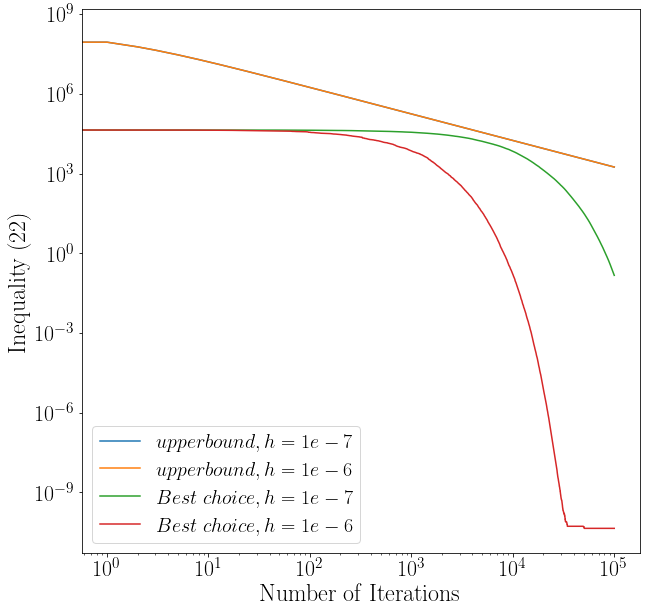

In [15]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 24}
font1 = {'family': 'serif', 'size': 20}
t = np.array(range(num_iterations+1))
plt.figure(figsize=(10,10))
plt.xticks(fontname='serif', fontsize=22, color='black')
plt.yticks(fontname='serif', fontsize=22, color='black')
plt.plot(t,up1,'-',label= '$upper bound, h=1e-7$')
plt.plot(t,up2,'-',label= '$upper bound, h=1e-6$')
# plt.plot(t,up2,'-',label= '$upper bound, h=1e-8$')
plt.plot(t,bf1,label= r'$Best\; choice, h=1e-7$')
plt.plot(t,bf2,label = r'$Best\; choice, h=1e-6$')
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=24)
plt.ylabel(r'$\mathrm{Inequality\; (22)}$', fontdict=font)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best', prop=font1)

In [30]:
def f(x):
    return np.linalg.norm(np.dot(A,x)-y0)**2
n = 100
m = 1000
T =25
num_iterations=200000
f1 = np.zeros((T,num_iterations+1)) 
f2 = np.zeros((T,num_iterations+1))
for j in range(T):
    A = np.random.randn(n, m)
    x_star1 = np.random.randn(m)
    epsilon = 0.01 * np.random.randn(n)
    y0 = np.dot(A,x_star1) + epsilon
    x_initial = np.random.randn(m)
    x_star = A.T@np.linalg.inv(A@A.T)@y0
    k = Nesterov(f,x_initial,num_iterations,h = 1e-7,mu=1e-7,flag = 'noth')
    k1 = Nesterov(f,x_initial,num_iterations,h = 1e-6,mu=1e-7,flag = 'noth')
    for i in range (np.shape(k)[1]):
        f1[j,i]=f(k[:,i])
        f2[j,i]=f(k1[:,i])

In [10]:
# np.save('f11.npy', f1)
# np.save('f12.npy', f2)
f1 = np.load('f11.npy')
f2 = np.load('f12.npy')

In [11]:
num_iterations=200000
f1_avg = np.mean(f1, axis=0)
f2_avg = np.mean(f2, axis=0)

2.839131330192179e-10 2.944734457140117e-09


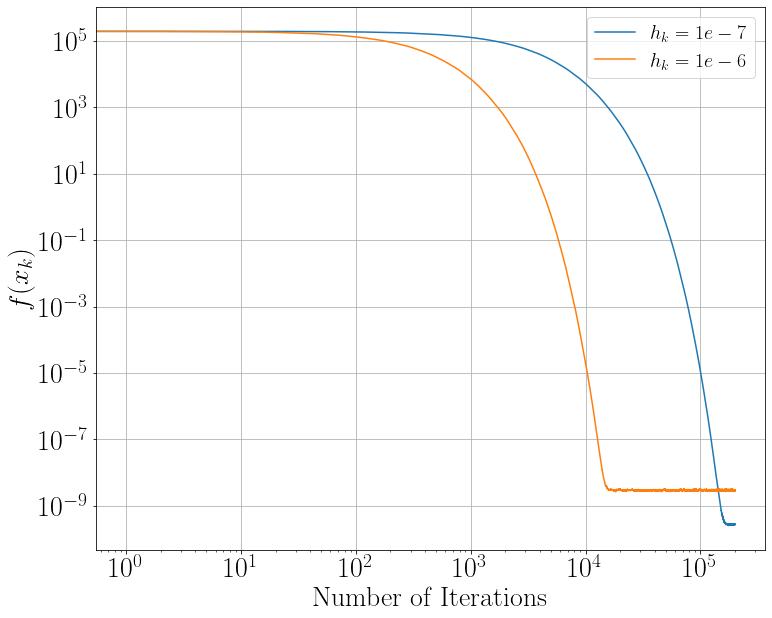

In [12]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 24}
font1 = {'family': 'serif', 'size': 20}
t = np.array(range(num_iterations+1))
print(f1_avg[-1],f2_avg[-1])
plt.figure(figsize=(12,10))
plt.xticks(fontname='serif', fontsize=28, color='black')
plt.yticks(fontname='serif', fontsize=28, color='black')
plt.plot(t,f1_avg,label= r'$h_{k}=1e-7$')
plt.plot(t,f2_avg,label = r'$h_{k}=1e-6$')
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$f(x_{k})$', fontsize=28)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend(loc='best', prop=font1)
plt.savefig('Pics/res_LSF_unc.pdf', format='pdf')

In [ ]:
l = 2*np.linalg.norm(A.T,ord=2)**2
L=2*np.linalg.norm(A.T@A,ord=2)
n = m
mu=1e-7
f0=f(x_initial)
print((8*(n+4)*L/l)*(f0/(num_iterations+1)+3*mu**2*(n+4)*L/32)+(mu**2*L**2*(n+6)**3/(4*l)))
print((8*(n+4)*L/l)*(f0/(num_iterations+1)))
print((8*(n+4)*L/l),f0)
print((8*(n+4)*L/l)*(3*mu**2*(n+4)*L/32))
print(mu**2*L**2*(n+6)**3/(4*l))

In [36]:
def upper(f,x_0,x_as,N):
    l = 2*np.linalg.norm(A.T,ord=2)**2
    L=2*np.linalg.norm(A.T@A,ord=2)
    n = m
    mu=1e-7
    up = np.zeros(N+1)
    f0=f(x_0)
    for i in range(N+1):
        up[i]=(8*(n+4)*L/l)*(f0/(i+1)+3*mu**2*(n+4)*L/32)+(mu**2*L**2*(n+6)**3/(4*l))
    return up

def best_choice(x):
    result = np.zeros_like(x)
    for j in range(np.shape(x)[0]):
        for i in range(np.shape(x)[1]):
            result[j,i]=(np.min(x[j,0:i+1]))
    return np.mean(result,axis=0)

x_ast = x_star
up1 = upper(f,x_initial,x_ast,num_iterations)   
bf1 = best_choice(f1)
bf2 = best_choice(f2)




In [14]:
# np.save('bf1.npy', bf1)
# np.save('bf2.npy', bf2)
# np.save('up1.npy', up1)
bf1 = np.load('bf1.npy')
bf2 = np.load('bf2.npy')
up1 = np.load('up1.npy')

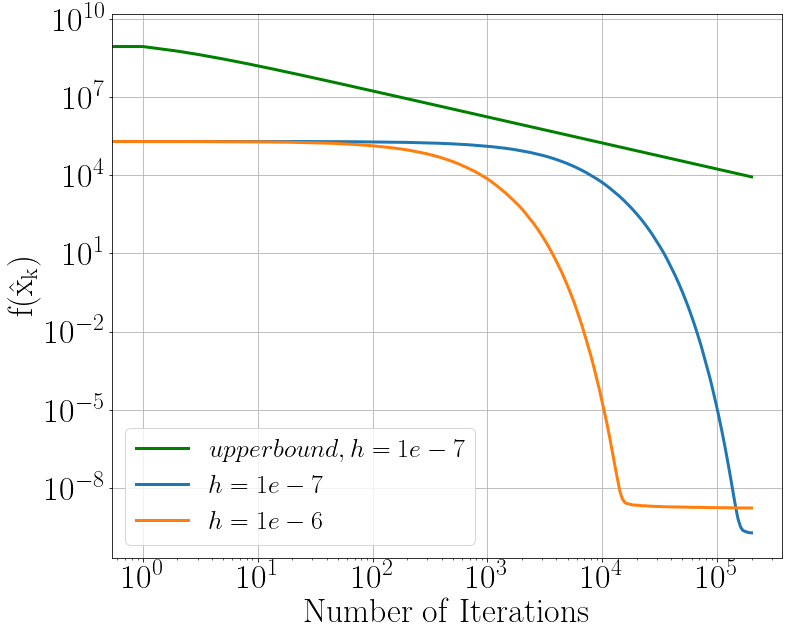

In [37]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 34}
font1 = {'family': 'serif', 'size': 26}
t = np.array(range(num_iterations+1))
plt.figure(figsize=(12,10))
plt.xticks(fontname='serif', fontsize=34, color='black')
plt.yticks(fontname='serif', fontsize=34, color='black')
plt.plot(t,up1,'-',color='green',label= '$upper bound, h=1e-7$',linewidth=3)
# plt.plot(t,up2,'-',label= '$upper bound, h=1e-8$')
plt.plot(t,bf1,label= r'$h=1e-7$',linewidth=3)
plt.plot(t,bf2,label = r'$h=1e-6$',linewidth=3)
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=34)
plt.ylabel(r'$\mathrm{f(\hat{x}_k)}$', fontdict=font)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend(loc='best', prop=font1)
plt.savefig('Pics/LSF_upper_unc.pdf', format='pdf',bbox_inches='tight')

In [25]:
2*np.linalg.norm(A.T@A,ord=2)

1677.2585602669537

In [ ]:
def f(x):
    return np.linalg.norm(np.dot(A,x)-y0)**2
n = 100
m = 1000
T =25
num_iterations=200000
ff1 = np.zeros((T,num_iterations+1)) 
ff2 = np.zeros((T,num_iterations+1))
for j in range(T):
    A = np.random.randn(n, m)
    x_star1 = np.random.randn(m)
    epsilon = 0.01 * np.random.randn(n)
    y0 = np.dot(A,x_star1) + epsilon
    x_initial = np.random.randn(m)
    x_star = A.T@np.linalg.inv(A@A.T)@y0
    k = Nesterov(f,x_initial,num_iterations,h = 1e-7,mu=1e-10,flag = 'noth',flag2='c',lower_bounds=np.ones(m)*(-0.5),upper_bounds=0.5*np.ones(m))
    k1 = Nesterov(f,x_initial,num_iterations,h = 1e-6,mu=1e-10,flag = 'noth',flag2='c',lower_bounds=np.ones(m)*(-0.5),upper_bounds=0.5*np.ones(m))
    for i in range (np.shape(k)[1]):
        ff1[j,i]=f(k[:,i])
        ff2[j,i]=f(k1[:,i])

In [32]:
# np.save('f21.npy', ff1)
# np.save('f22.npy', ff2)
# ff1 = np.load('f21.npy')
# ff2 = np.load('f22.npy')

In [33]:
def best_choice(x):
    result = np.zeros_like(x)
    for j in range(np.shape(x)[0]):
        for i in range(np.shape(x)[1]):
            result[j,i]=(np.min(x[j,0:i+1]))
    return np.mean(result,axis=0)

bff1 = best_choice(ff1)
bff2 = best_choice(ff2)

In [34]:
# np.save('bff1.npy', bff1)
# np.save('bff2.npy', bff2)
bff1 = np.load('bff1.npy')
bff2 = np.load('bff2.npy')

In [25]:
# num_iterations=200000
# f1_avg = np.mean(ff1, axis=0)
# f2_avg = np.mean(ff2, axis=0)

0.9007625852518025 2.9081581153017573e-15


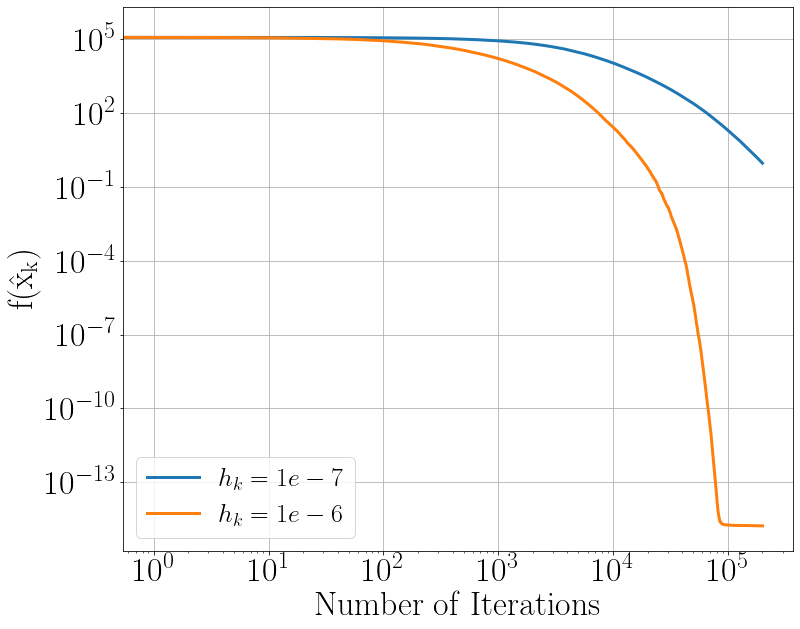

In [36]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 34}
font1 = {'family': 'serif', 'size': 26}
t = np.array(range(num_iterations+1))
print(f1_avg[-1],f2_avg[-1])
plt.figure(figsize=(12,10))
plt.xticks(fontname='serif', fontsize=34, color='black')
plt.yticks(fontname='serif', fontsize=34, color='black')
plt.plot(t,bff1,label= r'$h_{k}=1e-7$',linewidth=3)
plt.plot(t,bff2,label = r'$h_{k}=1e-6$',linewidth=3)
plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=34)
plt.ylabel(r'$\mathrm{f(\hat{x}_k)}$', fontdict=font)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.savefig('Pics/res_LSF_con.pdf', format='pdf',bbox_inches='tight')